# Week 6

This week, we continue improving neural networks by considering a new issue:

* Vanishing and Exploding Gradients -- when gradients of different layers vary tremendously, resulting in poor learning

# Lecture 11 - Sept 27 - Vanishing and Exploding Gradients

**Deep** neural networks (i.e. models with many hidden layers) offer an opportunity to learn much more complex patterns in high-dimensional data. However, training deep networks presents some challenges. It is difficult to maintain gradients throughout the network that allow the many parameters of the model to learn in an effective manner.

In particular, we have learned that backpropagation starts with the output layer where the loss is computed, and propagates the loss backward through the network, computing the partial derivatives with respect to the weights just before the output layer, then weights in the previous layer, and the previous layer, and so on, until we reach the weights coming from the input layer. Recall, the partial derivatives propagate backwards as

$$\delta^l=\left(\left(w^{l+1}\right)^T\delta^{l+1}\right) \odot \sigma'\left(z^l\right)$$

where $\sigma$ is a common activation function for each neuron. This indicates the partial derivatives for weights in layer $l$ are the partial derivatives in layer $l+1$ multiplied by several terms.

Mathematically speaking, each partial derivative is constructed by repeated multiplication, with earlier layers made up of products of more terms. Repeated multiplication is inherently pretty unstable:

* If just one term nears 0, the whole product might **vanish** to 0
* If just one term grows a lot, the whole product might **explode** to a high value

In other words, the gradients are at risk to vanish or explode during the training process.

If the partial derivatives for the earlier weights vanish (go to 0), these weights will have gradient-based weight updates near 0, meaning the weights get stuck. Hence, the corresponding weights do not learn anything and our (expensive) backprop calculations cost a lot of time without yielding benefits.

If the partial derivatives for any weights explore (get very large), these weights will have huge gradient-based weight updates, sending the weights to large values. Note that backpropagation involves multiplications by the weights, causing the gradients to get even larger leading the model to blow up and cause overflows.

In the first case, the model may learn, but we waste computation. In the second case, the model doesn't converge at all. In both cases, deep nets can fail to live up to their potential.

**(See more details on this issue and mitigating it in class.)**

# Using Keras

Since computation is a bottleneck for neural nets, it is worthwhile to learn to construct neural nets with a dedicated deep learning framework rather than simply raw Python with NumPy, as we have used so far, because they allow highly optimized computation accelerated by graphics processing units (GPUs) and let us create nets quickly and easily.

As of now, the most popular solutions are Meta's PyTorch and Google's TensorFlow with Keras. (There are some other solutions like Theano, Caffe, and MXNet as well.) Both have two main parts: (1) highly optimized tensor computing, including matrix multiplication and (2) simple functionality for creating neural networks with optimized backpropagation.

We will use Keras today.

### Writing a Fully-connected Feedforward Neural Net with Keras

We will aim to write a neural net similar to what we have constructed through the course so far. That is, it should feed data forward through a sequence of layers, the layers should be fully connected (dense), and we should use SGD to optimize it. We can import these things directly from Keras.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report

Let's construct the net to classify MNIST (our beloved benchmarking dataset) on a vanilla neural network (SGD, sigmoid, SSE loss) with two hidden layers

In [2]:
# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, activation = 'sigmoid', input_shape=(784,))) # hidden layer 1
model.add(Dense(128, activation = 'sigmoid')) # hidden layer 2
model.add(Dense(10, activation = 'sigmoid')) # output layer

# compile the model by choosing how the optimizer works
model.compile(loss = 'mean_squared_error', optimizer = SGD(0.5), metrics = ['accuracy'])

# print a summary of the model
model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Now, let's read in MNIST

In [8]:
# read in full MNIST
(trainX, trainY), (testX, testY) = mnist.load_data()

# reshape into vectors
trainX = trainX.reshape((trainX.shape[0], 28 * 28 * 1))
testX = testX.reshape((testX.shape[0], 28 * 28 * 1))

# scale the data to [0,1]
trainX = trainX/255.0
testX = testX/255.0

# convert the labels to one-hot form
trainY = to_categorical(trainY)
testY = to_categorical(testY)

Next, let's classify MNIST with our vanilla net.

Epoch 1/100
469/469 [==============================] - 3s 5ms/step - loss: 0.0907 - accuracy: 0.1746 - val_loss: 0.0889 - val_accuracy: 0.1704
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0882 - accuracy: 0.2961 - val_loss: 0.0873 - val_accuracy: 0.3140
Epoch 3/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0858 - accuracy: 0.3623 - val_loss: 0.0836 - val_accuracy: 0.3817
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0801 - accuracy: 0.4193 - val_loss: 0.0754 - val_accuracy: 0.4834
Epoch 5/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0705 - accuracy: 0.5313 - val_loss: 0.0649 - val_accuracy: 0.5698
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0604 - accuracy: 0.6199 - val_loss: 0.0556 - val_accuracy: 0.6655
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0524 - accuracy: 0.6886 - val_loss: 0.0487 - val_accuracy: 0.7155

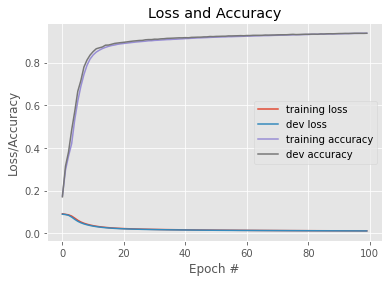

In [9]:
# fit the model to the training data
maxEpoch = 100
H = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpoch, batch_size = 128)

print('Test accuracy')

# predict posterior probability distribution for labels of the test set
predictedY = model.predict(testX)

# convert posterior probabilities to labels
predictedY = predictedY.argmax(axis = 1)
realY = testY.argmax(axis = 1)

# print classification report
print(classification_report(realY, predictedY))

# plot the loss and accuracy through training
plt.style.use('ggplot')
plt.figure()

plt.plot(np.range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(np.range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(np.range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(np.range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title('Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

Let's try a more modern version using ReLU and softmax layers with categorical crossentropy loss, the ADAM optimizer, and both $L^1$ and $L^2$ regularization.

In [34]:
# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, input_shape = (784,), activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.0001)))
model.add(Dense(128, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.0001)))
model.add(Dense(10, activation = 'softmax', kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.0001)))

# compile the model by choosing how the optimizer works
model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])

# print a summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


Let's use this more modern network to classify MNIST

Epoch 1/100
469/469 [==============================] - 1s 3ms/step - loss: 0.3152 - accuracy: 0.9237 - val_loss: 0.1747 - val_accuracy: 0.9605
Epoch 2/100
469/469 [==============================] - 1s 3ms/step - loss: 0.1563 - accuracy: 0.9680 - val_loss: 0.1374 - val_accuracy: 0.9731
Epoch 3/100
469/469 [==============================] - 1s 3ms/step - loss: 0.1240 - accuracy: 0.9773 - val_loss: 0.1306 - val_accuracy: 0.9753
Epoch 4/100
469/469 [==============================] - 1s 3ms/step - loss: 0.1075 - accuracy: 0.9826 - val_loss: 0.1271 - val_accuracy: 0.9758
Epoch 5/100
469/469 [==============================] - 1s 3ms/step - loss: 0.0954 - accuracy: 0.9857 - val_loss: 0.1237 - val_accuracy: 0.9770
Epoch 6/100
469/469 [==============================] - 1s 3ms/step - loss: 0.0901 - accuracy: 0.9876 - val_loss: 0.1144 - val_accuracy: 0.9801
Epoch 7/100
469/469 [==============================] - 1s 3ms/step - loss: 0.0830 - accuracy: 0.9898 - val_loss: 0.1109 - val_accuracy: 0.9797

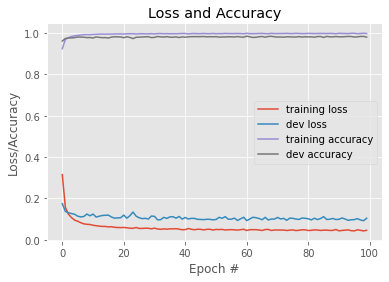

In [35]:
# fit the model to the training data
maxEpoch = 100
H = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpoch, batch_size = 128)

print('Test accuracy')

# predict posterior probability distribution for labels of the test set
predictedY = model.predict(testX)

# convert posterior probabilities to labels
predictedY = predictedY.argmax(axis = 1)
realY = testY.argmax(axis = 1)

# print classification report
print(classification_report(realY, predictedY))

# plot the loss and accuracy through training
plt.style.use('ggplot')
plt.figure()

plt.plot(np.arange(0, maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(np.arange(0, maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(np.arange(0, maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(np.arange(0, maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title('Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

As expected, this is a little better.

### Writing a Fully-connected Feedforward Neural Net with PyTorch

We will aim to write a neural net similar to what we have constructed through the course so far. That is, it should feed data forward through a sequence of layers, the layers should be fully connected (dense), and we should use SGD to optimize it. We can import these things directly from PyTorch.